# Quantitative Methods Workshop: Coding Demonstration
## 4 October 2016

## Paper

Aronow, P.M. & Samil, C. (2016). '[Does Regression Produce Representative Estimates of Causal Effects?](http://onlinelibrary.wiley.com/doi/10.1111/ajps.12185/abstract;jsessionid=9FB66029C4A477110EB80246474F20B7.f04t03)' *American Journal of Political Science)*, 60(1), p. 250-267. doi:10.1111/ajps.12185

## Setup

In [1]:
# libraries
libs = c('dplyr', 'ggplot2', 'readr', 'rgdal', 'mapdata', 'repr')
suppressMessages(lapply(libs, require, character.only = TRUE))

# options
options(repr.plot.width = 10, repr.plot.height = 6)
options(scipen = 999, width = 90)

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

## Read in data

In [2]:
df = read_csv('./data/online.csv')

## Simple linear model

In [3]:
# fit
mod = lm(log(efdesom + 1)     # number of students taking some distance education courses
         ~ wmdown             # weighted download speed
         + twoyr              # == 1 if two-year institution
         + privnp             # == 1 if private, non-profit
         + privfp             # == 1 if private, for-profit
         + openadmp           # == 1 if open admissions
         + log(efteug)        # effective fulltime enrollment
         + log(upgrntn + 1)   # number of Pell grant recipients
         + log(pttot + 1)     # number of part-time students
         + log(age25o + 1)    # number of students 25 years old +
         + ctbapct            # % in county w/bachelor's or above
         + ctpopdens          # number of people in county/sq.mile
         + ctmedianinc        # median income in county ($1000s)
         + factor(rucc)       # rurality/urbanicity
         + factor(stname)     # state
         + factor(year),      # year (2012, 2013)
         data = df)

# print
summary(mod)


Call:
lm(formula = log(efdesom + 1) ~ wmdown + twoyr + privnp + privfp + 
    openadmp + log(efteug) + log(upgrntn + 1) + log(pttot + 1) + 
    log(age25o + 1) + ctbapct + ctpopdens + ctmedianinc + factor(rucc) + 
    factor(stname) + factor(year), data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0559 -0.7281  0.1170  0.8150  5.2046 

Coefficients:
                                 Estimate   Std. Error t value             Pr(>|t|)    
(Intercept)                  -1.593164985  0.452608887  -3.520             0.000435 ***
wmdown                        0.048157419  0.053474626   0.901             0.367856    
twoyr                         0.252242834  0.050990911   4.947        0.00000077500 ***
privnp                       -0.883351449  0.073767678 -11.975 < 0.0000000000000002 ***
privfp                       -1.208266087  0.082003996 -14.734 < 0.0000000000000002 ***
openadmp                     -0.795108279  0.058587760 -13.571 < 0.0000000000000002 ***
log(efteug)   

## Compute weights 

### Formulas

$w_i = (D_i - \mathbf{V}_i\hat{\omega})^2 = (D_i - \mathbf{E}[D_i\mid\mathbf{X}_i])^2 = \tilde{D}_i$


In [4]:
# regression Xs on D
mod2 = lm(wmdown
          ~ twoyr
          + privnp
          + privfp
          + openadmp
          + log(efteug)
          + log(upgrntn + 1)
          + log(pttot + 1)
          + log(age25o + 1)
          + ctbapct
          + ctpopdens
          + ctmedianinc
          + factor(rucc)
          + factor(stname)
          + factor(year),
          data = df)

# residuals
r = residuals(mod2)

# weights
w = r^2

# proportion of variance
pv = w / sum(w)

# add pv column to df
df = df %>% bind_cols(data.frame('pv' = pv))

## Map

In [5]:
# get map data and join w/data aggregated to state level
map = map_data('state') %>%
    left_join(df %>%
              group_by(stname) %>%
              summarise(stpv = sum(pv)) %>%
              arrange(-stpv) %>%
              mutate(rank = row_number(),
                     region = tolower(stname),
                     top10 = ifelse(rank < 11, 1, 0),
                     bottom10 = ifelse(rank > 40, 1, 0)),
              by = 'region')

### Top 10 states contributing to effective sample

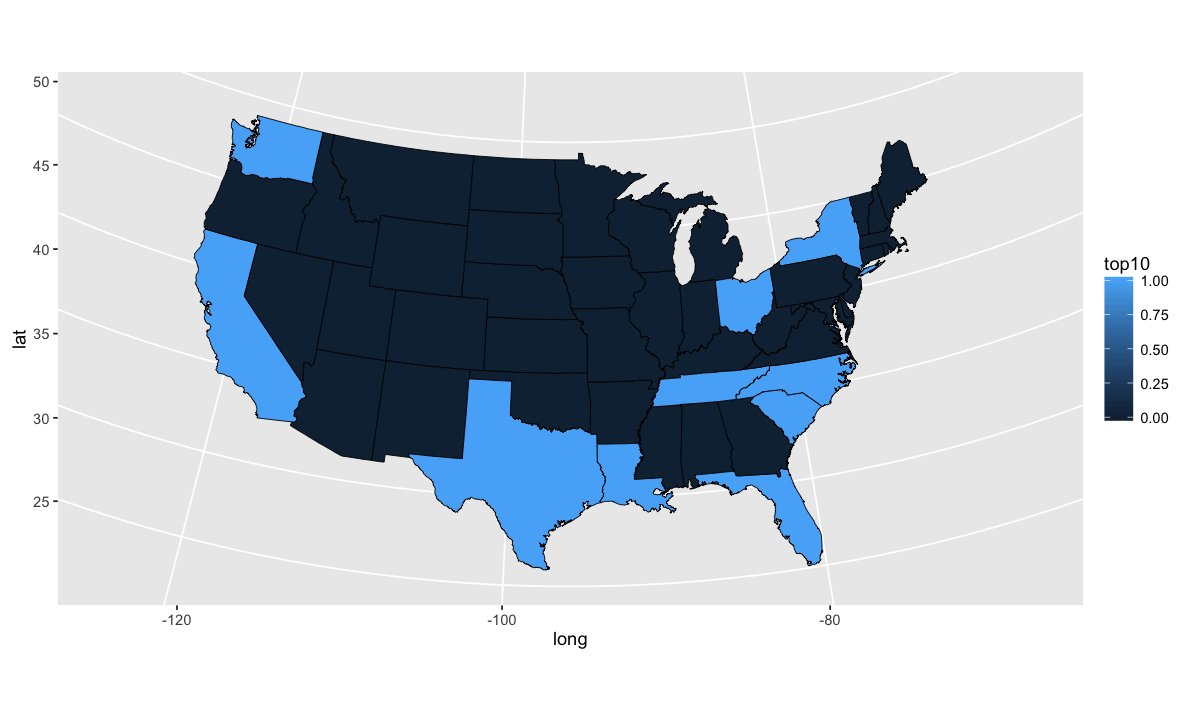

In [6]:
# plot
ggplot() +
    geom_polygon(data = map, aes(x = long, y = lat, group = group, fill = top10), 
                 color = "black", size = 0.25) +
    coord_map("albers",  at0 = 45.5, lat1 = 29.5)

### Bottom 10 states in effective sample

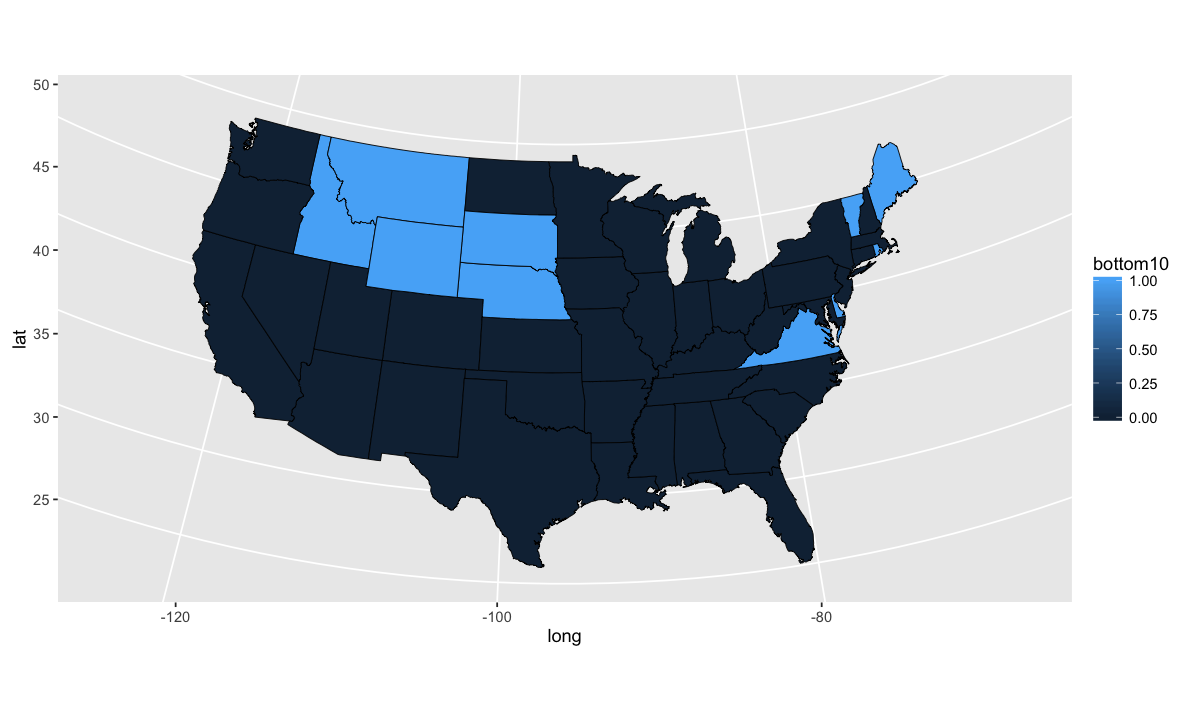

In [7]:
# plot
ggplot() +
    geom_polygon(data = map, aes(x = long, y = lat, group = group, fill = bottom10), 
                 color = "black", size = 0.25) +
    coord_map("albers",  at0 = 45.5, lat1 = 29.5)

## Summary stats

In [8]:
# vector of right hand side covariates
rhs = c('twoyr', 'privnp', 'privfp', 'openadmp', 'efteug', 'upgrntn', 'pttot', 'age25o', 
           'ctbapct', 'ctpopdens', 'ctmedianinc')

# init lists
mean_list = list()
sd_list = list()
wmean_list = list()
wsd_list = list()
sig_list = list()

# loop through
for(i in rhs) {
    
    # unweighted mean/sd
    mean_list[[i]] = round(mean(df[[i]]), 2)
    sd_list[[i]] = round(sd(df[[i]]),3)
    
    # weighted mean/sd
    wmean_list[[i]] = round(weighted.mean(x = df[[i]], w = df[['pv']]),2)
    wsd_list[[i]] = round(sqrt(sum(df[['pv']] * (df[[i]] - mean(df[[i]]))^2)),3)
    
    # significantly different?
    t = (mean_list[[i]] - wmean_list[[i]]) / sqrt(sd_list[[i]] / nrow(df) + wsd_list[[i]] / nrow(df))
    sig_list[[i]] = ifelse(abs(t) > qt(.9995, df = nrow(df) - 1), 'p < 0.001',
                          ifelse(abs(t) > qt(.995, df = nrow(df) - 1), 'p < 0.01', 
                                 ifelse(abs(t) > qt(.975, df = nrow(df) - 1), 'p < 0.05', '')))
}

# bind
out_table = cbind(mean_list, sd_list, wmean_list, wsd_list, sig_list)

# print
out_table

,mean_list,sd_list,wmean_list,wsd_list,sig_list
twoyr,0.3,0.459,0.32,0.468,
privnp,0.18,0.387,0.17,0.38,
privfp,0.48,0.5,0.42,0.497,p < 0.001
openadmp,0.67,0.468,0.68,0.468,
efteug,3587.8,6720.371,3727.93,6490.33,p < 0.001
upgrntn,1743.09,3847.638,1810.64,2999.731,p < 0.001
pttot,1698.56,3841.724,1629.27,3614.65,p < 0.001
age25o,1363.31,3856.396,1268.47,2650.326,p < 0.001
ctbapct,27.04,8.563,24.08,8.45,p < 0.001
ctpopdens,2381.86,7807.916,900.1,3107.001,p < 0.001


## Binary treatment: Open Admissions Policy

In [9]:
# regression Xs on D
mod3 = lm(openadmp
          ~ wmdown
          + twoyr
          + privnp
          + privfp
          + log(efteug)
          + log(upgrntn + 1)
          + log(pttot + 1)
          + log(age25o + 1)
          + ctbapct
          + ctpopdens
          + ctmedianinc
          + factor(rucc)
          + factor(stname)
          + factor(year),
          data = df)

# residuals
r = residuals(mod3)

# weights
w = r^2

# proportion of variance
pv2 = w / sum(w)

# add pv column to df
df = df %>% bind_cols(data.frame('pv2' = pv2))

In [10]:
# get map data and join w/data aggregated to state level
map2 = map_data('state') %>%
    left_join(df %>%
              group_by(stname) %>%
              summarise(stpv = sum(pv2)) %>%
              arrange(-stpv) %>%
              mutate(rank = row_number(),
                     region = tolower(stname),
                     top10 = ifelse(rank < 11, 1, 0),
                     bottom10 = ifelse(rank > 40, 1, 0)),
              by = 'region')

### Top 10

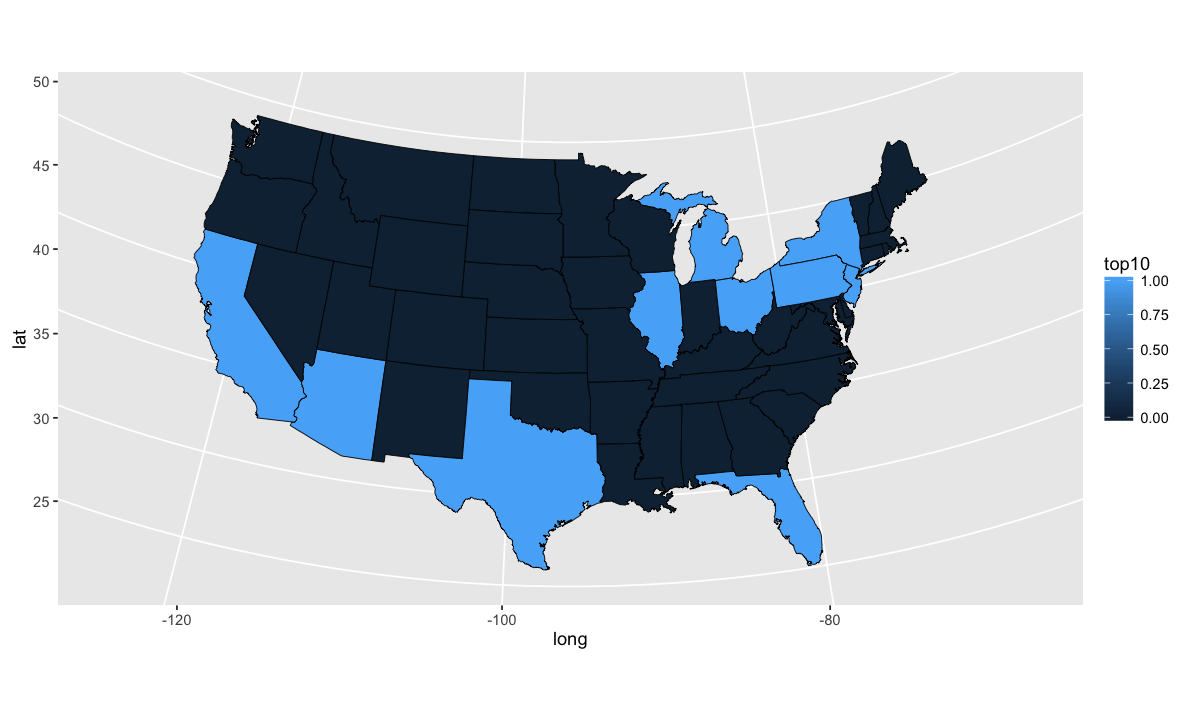

In [11]:
# plot
ggplot() +
    geom_polygon(data = map2, aes(x = long, y = lat, group = group, fill = top10), 
                 color = "black", size = 0.25) +
    coord_map("albers",  at0 = 45.5, lat1 = 29.5)

### Bottom 10

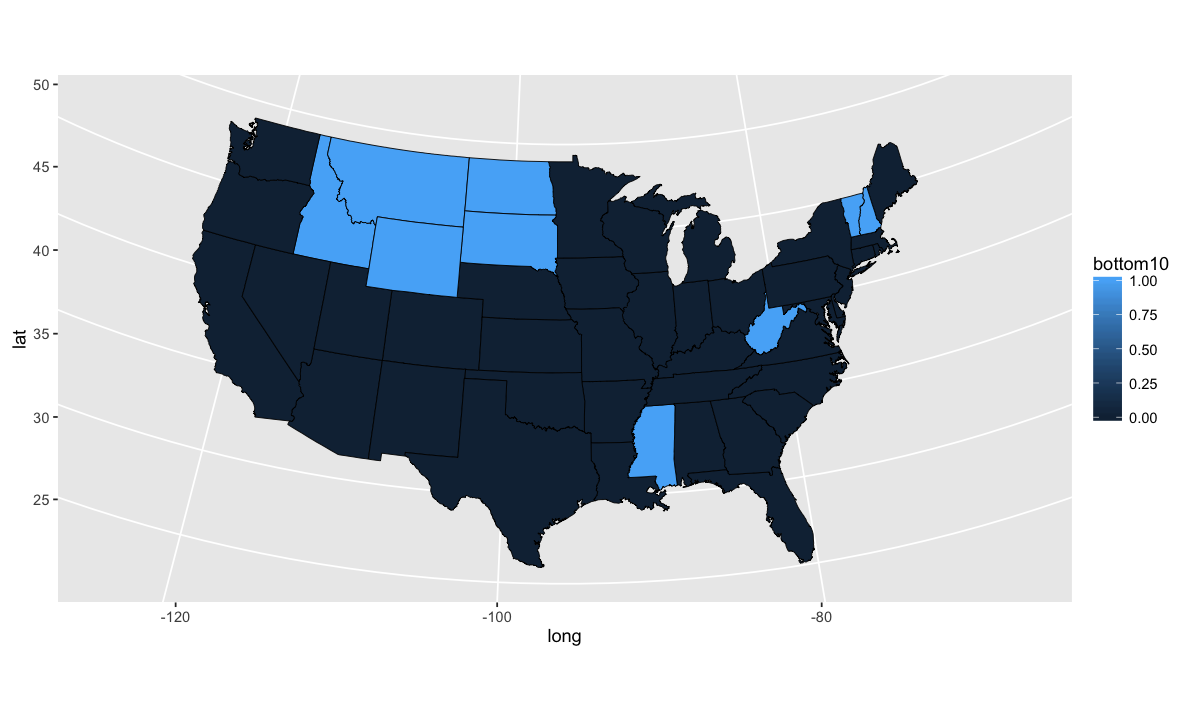

In [12]:
# plot
ggplot() +
    geom_polygon(data = map2, aes(x = long, y = lat, group = group, fill = bottom10), 
                 color = "black", size = 0.25) +
    coord_map("albers",  at0 = 45.5, lat1 = 29.5)